In [1]:
import geopandas as gpd
import pandas as pd
import glob
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/bsuhome/yavarpourmohamad/miniforge3/envs/ML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# FPA FOD

In [2]:
nwcg = pd.read_csv(filepath_or_buffer = '/bsuhome/yavarpourmohamad/scratch/Dissertation/Code/Karen_email/NWCG_UnitIdActive_20200123.csv', sep = ',')
cols_FPA = ['STATE', 'FIRE_YEAR', 'DISCOVERY_DATE', 'NWCG_GENERAL_CAUSE', 'LONGITUDE', 'LATITUDE']
FPA_FOD = pd.read_csv(filepath_or_buffer = '/bsuhome/yavarpourmohamad/scratch/Dissertation/Data/FPA_FOD/FPA_FOD_Plus.csv',
                      sep = ',', low_memory = False)
sts = ['WA', 'OR', 'CA', 'ID', 'NV', 'MT', 'WY', 'UT', 'AZ', 'CO', 'NM']
sts.sort()
FPA_FOD = FPA_FOD.loc[FPA_FOD['STATE'].isin(sts)]
FPA_FOD = FPA_FOD.loc[FPA_FOD['LONGITUDE'] < -102.05]
FPA_FOD = pd.merge(left = FPA_FOD,
                   left_on = 'NWCG_REPORTING_UNIT_ID',
                   right = nwcg[['UnitId', 'UnitType']],
                   right_on = 'UnitId',
                   how = 'left')
FPA_FOD = FPA_FOD[~((FPA_FOD['FIRE_SIZE'] <= 0.1) & (FPA_FOD['Land_Cover'].isin([22, 23, 24])) & (FPA_FOD['UnitType'].isin(['US County/Local'])))]
FPA_FOD = FPA_FOD[cols_FPA]
cause_dic =  {'Debris and open burning': 'Debris',
              'Arson/incendiarism': 'Arson',
              'Recreation and ceremony': 'Recreation',
              'Missing data/not specified/undetermined': 'Missing',
              'Equipment and vehicle use': 'Equipment',
              'Power generation/transmission/distribution': 'Power',
              'Misuse of fire by a minor': 'Misuse by minor',
              'Firearms and explosives use': 'Firearms',
              'Railroad operations and maintenance': 'Railroad'}
FPA_FOD['NWCG_GENERAL_CAUSE'] = FPA_FOD['NWCG_GENERAL_CAUSE'].replace(cause_dic)              
FPA_FOD = FPA_FOD[~FPA_FOD['NWCG_GENERAL_CAUSE'].isin(['Other causes', 'Missing'])]
FPA_FOD = FPA_FOD.loc[FPA_FOD['FIRE_YEAR'] > 2015, ]

In [3]:
FPA_FOD['DISCOVERY_DATE'] = pd.to_datetime(arg=FPA_FOD['DISCOVERY_DATE'])
FPA_FOD['season'] = FPA_FOD['DISCOVERY_DATE'].dt.month.apply(lambda x: 'Dec-Feb' if x in [12, 1, 2] else 
                                                                       'Mar-May' if x in [3, 4, 5] else
                                                                       'Jun-Aug' if x in [6, 7, 8] else
                                                                       'Sep-Nov')
igni_load = FPA_FOD.groupby(by=['STATE', 'FIRE_YEAR', 'season', 'NWCG_GENERAL_CAUSE']).size().reset_index(name='counts')
igni_load['source'] = 'Ignition load'

# 2015-2016

In [6]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

newCmapp = {
    'Power': '#a6cee3',
    'Equipment': '#1f78b4',
    'Recreation': '#b2df8a',
    'Debris': '#33a02c',
    'Arson': '#fb9a99',
    'Misuse by minor': '#e31a1c',
    'Natural': '#fdbf6f',
    'Firearms': '#ff7f00',
    'Fireworks': '#cab2d6',
    'Railroad': '#ffff99',
    'Smoking': '#b15928'
}
causes = ['Natural', 'Debris', 'Fireworks', 'Arson', 'Recreation', 'Smoking',
          'Equipment', 'Power', 'Misuse by minor', 'Firearms', 'Railroad']
sts = ['WA', 'OR', 'CA', 'ID', 'NV', 'MT', 'WY', 'UT', 'AZ', 'CO', 'NM']
sts.sort()

csv_list = glob.glob(pathname='/bsuhome/yavarpourmohamad/scratch/Dissertation/Cause_specific/Time_series_grid/yearly/ts_data_cause20*.csv')
csv_list.sort()

In [7]:
pot_igni_load = []
for csv in tqdm(csv_list[:]):
    year = ''.join(c for c in csv if c.isdigit())
    temp = pd.read_csv(filepath_or_buffer=csv, sep=',', low_memory=False)
    temp['date'] = pd.to_datetime(temp['date'])
    temp['season'] = temp['date'].dt.month.apply(lambda x: 'Dec-Feb' if x in [12, 1, 2] else 
                                                            'Mar-May' if x in [3, 4, 5] else
                                                            'Jun-Aug' if x in [6, 7, 8] else
                                                            'Sep-Nov')
    temp = temp.groupby(by=['STATE', 'season'])[causes].sum().reset_index()
    temp['FIRE_YEAR'] = year
    temp = temp.melt(id_vars=['STATE', 'FIRE_YEAR', 'season'],
                     value_vars=causes,
                     var_name='NWCG_GENERAL_CAUSE',
                     value_name='counts')
    pot_igni_load.append(temp)

pot_igni_load = pd.concat(objs=pot_igni_load)
pot_igni_load['FIRE_YEAR'] = pot_igni_load['FIRE_YEAR'].astype('int64')
pot_igni_load['source'] = 'Potential ignition load'

100%|██████████| 5/5 [11:41<00:00, 140.38s/it]


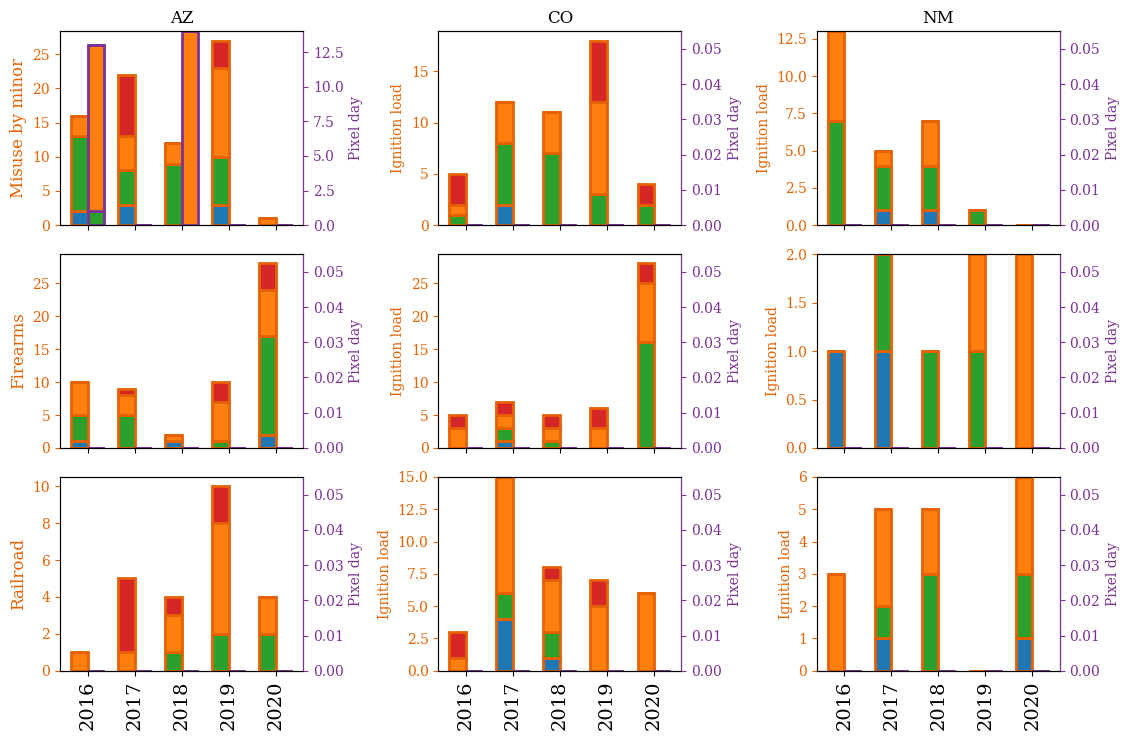

In [18]:
plt_df = pd.concat(objs=[igni_load, pot_igni_load])
agg_df = plt_df.groupby(["STATE", "NWCG_GENERAL_CAUSE", "FIRE_YEAR", "source", "season"])["counts"].sum().reset_index()
agg_df.to_csv(path_or_buf='/bsuhome/yavarpourmohamad/scratch/Dissertation/Cause_specific/Mapping/ML_on_TS/Multibarplots.csv',
              sep=',', index=False)
pivot_df = agg_df.pivot_table(
    index=["STATE", "NWCG_GENERAL_CAUSE", "FIRE_YEAR", "source"],
    columns="season",
    values="counts",
    fill_value=0
).reset_index()

seasons = ["Dec-Feb", "Mar-May", "Jun-Aug", "Sep-Nov"]
colors_ignition = ["#1f77b4", "#2ca02c", "#ff7f0e", "#d62728"]   # Ignition load
colors_potential = ["#7b3294", "#c2a5cf", "#a6dba0", "#008837"]  # Potential ignition load
states = sorted(plt_df["STATE"].unique())
causes = sorted(plt_df["NWCG_GENERAL_CAUSE"].unique())

causes = ['Misuse by minor', 'Firearms', 'Railroad']
sts = ['AZ', 'CO', 'NM']#['NV', 'MT', 'WY', 'UT']#['WA', 'OR', 'CA', 'ID']# # # 
n_rows, n_cols = len(causes), len(sts)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 2.5*n_rows), sharey=False, sharex=True)
bar_width = 0.35

for r, cause in enumerate(causes):
    for c, state in enumerate(sts):
        ax_left = axes[r, c] if n_rows > 1 else axes[c]
        ax_right = ax_left.twinx()  # dual y-axis

        subset = pivot_df[(pivot_df["STATE"] == state) & (pivot_df["NWCG_GENERAL_CAUSE"] == cause)]
        years = sorted(subset["FIRE_YEAR"].unique())
        x = range(len(years))

        # --- Ignition load (left axis) ---
        ignition_data = subset[subset["source"] == "Ignition load"].set_index("FIRE_YEAR")
        bottoms = [0]*len(years)
        for season, color in zip(seasons, colors_ignition):
            values = [ignition_data.loc[yr, season] if yr in ignition_data.index else 0 for yr in years]
            ax_left.bar(
                [p - bar_width/2 for p in x],
                values,
                bar_width,
                bottom=bottoms,
                color=color,
                linewidth=2,
                edgecolor="#e66101",
                label=season if (r==0 and c==0) else None
            )
            bottoms = [b+v for b,v in zip(bottoms, values)]

        # --- Potential ignition load (right axis) ---
        potential_data = subset[subset["source"] == "Potential ignition load"].set_index("FIRE_YEAR")
        bottoms = [0]*len(years)
        for season, color in zip(seasons, colors_ignition):
            values = [potential_data.loc[yr, season] if yr in potential_data.index else 0 for yr in years]
            ax_right.bar(
                [p + bar_width/2 for p in x],
                values,
                bar_width,
                bottom=bottoms,
                color=color,
                linewidth=2,
                edgecolor="#7b3294"
            )
            bottoms = [b+v for b,v in zip(bottoms, values)]
        
        ax_left.set_ylim(bottom=0)
        ax_right.set_ylim(bottom=0)

        ax_left.tick_params(axis='y', colors='#e66101', labelsize=10)
        ax_left.spines['left'].set_color('#e66101')
        ax_right.tick_params(axis='y', colors='#7b3294', labelsize=10)
        ax_right.spines['right'].set_color('#7b3294')
        ax_left.set_ylabel("Ignition load", color='#e66101')
        ax_right.set_ylabel("Pixel day", color='#7b3294')
        ax_left.set_xticks(x)
        ax_left.set_xticklabels(years, fontsize=14, rotation=90)
        
        if r == 0:
            ax_left.set_title(state, fontsize=12)
        if c == 0:
            ax_left.set_ylabel(cause, fontsize=12)

# Common legend (only once, for seasons of Ignition load)
# handles = [plt.Rectangle((0,0),1,1,color=color) for color in colors_ignition]
# fig.legend(handles, seasons, title="Season", bbox_to_anchor=(1.02, 0.5), loc="center left")

plt.tight_layout(rect=[0,0,0.95,1])
plt.show()